в случае отсутствия установить библиотеку \
pip install pandas \
pip install  matplotlib \
pip install eaborn \
pip install nltk \
pip install pymorphy3 \
pip install wordcloud \
pip install stop-words \
pip install pymystem3

In [1]:
# загрузка необходимых библиотек
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from pymystem3 import Mystem
import pymorphy3
from wordcloud import WordCloud
from stop_words import get_stop_words

%matplotlib inline

In [2]:
# задание формата отображения чисел
#pd.options.display.float_format ='{:,.2f}'.format

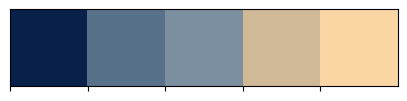

In [2]:
# задание палитры цветов
colors = ["#09214a", "#567189", "#7B8FA1", "#CFB997", "#FAD6A5"]
sns.palplot(sns.color_palette(colors))

### Данные с целевыми переменными

In [3]:
# загрузка данных с целевыми переменными
train_targets = pd.read_csv("data/train_targets.csv")
train_targets.head()

viewer_uid  age     sex  age_class
0    10087154   30    male          1
1    10908708   25  female          1
2    10190464   34    male          2
3    10939673   25    male          1
4    10288257   48    male          3

In [4]:
# признаки данных
train_targets.columns

Index(['viewer_uid', 'age', 'sex', 'age_class'], dtype='object')

**train_targets.csv** - целевые переменные пользователей из таблицы train_events
* viewer_uid - id пользователя
* age - возраст пользователя
* sex - пол пользователя
* age_class - возрастная категория пользователя

In [5]:
# проверка на наличие пропусков
train_targets.isna().sum()

viewer_uid    0
age           0
sex           0
age_class     0
dtype: int64

Пропусков данных **нет**

In [6]:
# проверка данных на соответствие типа
train_targets.dtypes

viewer_uid     int64
age            int64
sex           object
age_class      int64
dtype: object

**age_class** - категориальный признак

In [7]:
# количество уникальных значений
train_targets.nunique()

viewer_uid    180012
age               44
sex                2
age_class          4
dtype: int64

**180 012** - уникальных пользователей \
**4** - возрастные категории

In [8]:
# размерность данных
train_targets.shape

(180012, 4)

In [9]:
# проверка на наличие дубликатов
train_targets.duplicated().sum()

0

Дубликатов **нет**

In [10]:
# уникальные значение по признакам
for col_name in train_targets.columns[1:]:
    print(col_name, " : ", train_targets[col_name].unique())

age  :  [30 25 34 48 33 23 20 42 45 24 41 39 28 36 50 29 52 26 49 38 21 32 37 22
 19 31 46 43 53 35 27 54 44 40 51 47 18 16 17 11 14 15 13 12]
sex  :  ['male' 'female']
age_class  :  [1 2 3 0]


In [11]:
# возрастные категории по возрастам
train_targets.sort_values(by=["age_class", "age"]) .groupby("age_class")["age"].unique()

age_class
0             [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1             [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
2             [31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
3    [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 5...
Name: age, dtype: object

In [12]:
# наименование возразстных категорий
dict_age_class = {
    0 : "(9-20] лет",
    1 : "(20-30] лет",
    2 : "(30-40] лет",
    3 : "(40-60] лет"
    }

In [13]:
# признак наименования возрастной категории
train_targets["age_class_name"] = train_targets["age_class"].map(dict_age_class)

In [14]:
# вывод распределения дохода по сегментам
df_sex_count = train_targets["sex"].value_counts()
df_sex_count  

sex
female    90098
male      89914
Name: count, dtype: int64

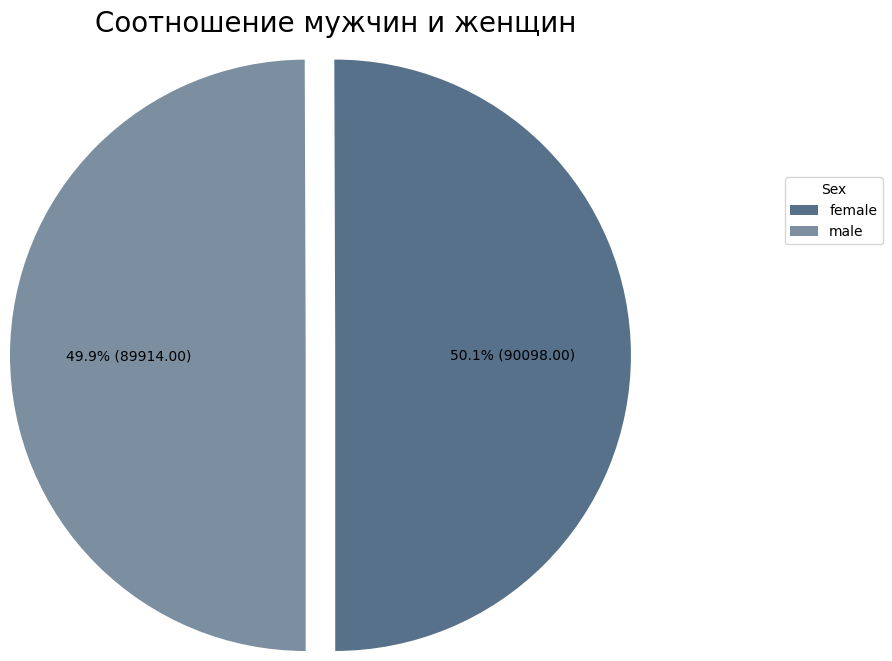

In [15]:
# визуализация соотношения мужчин и женщин
def func(pct, allvals):
    absolute = float(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:.2f})".format(pct, absolute)

plt.pie(df_sex_count, colors=colors[1:3], \
        autopct=lambda pct: func(pct, df_sex_count), radius=2, startangle = 270, explode = [0, 0.2])
plt.title("Cоотношение мужчин и женщин", size = 20, pad=100)
plt.legend(labels=df_sex_count.index, title ="Sex", loc="upper right", bbox_to_anchor =(1.5, 0, 0.5, 1))
plt.show()

Данные по **sex** - полу сбалансированы

In [16]:
# вывод распределения дохода по сегментам
df_age_class_name_count = train_targets["age_class_name"].value_counts()
df_age_class_name_count  

age_class_name
(30-40] лет    65600
(20-30] лет    63131
(40-60] лет    43690
(9-20] лет      7591
Name: count, dtype: int64

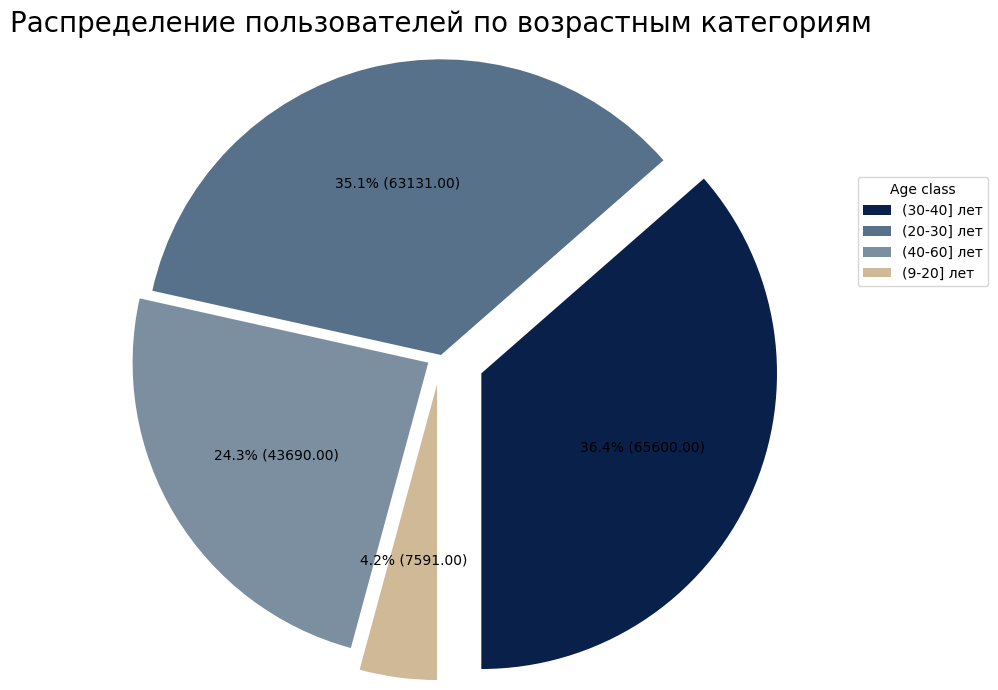

In [17]:
# визуализация соотношения распределения пользователей по возрастным категориям
plt.pie(df_age_class_name_count , colors=colors[:4], \
        autopct=lambda pct: func(pct, df_sex_count), radius=2, startangle = 270, explode = [0.3, 0, 0.1, 0.2])
plt.title("Распределение пользователей по возрастным категориям", size = 20, pad=100)
plt.legend(labels=df_age_class_name_count .index, title ="Age class", loc="upper right", bbox_to_anchor =(1.5, 0, 0.5, 1))
plt.show()

Исходя из распределения возрастных категорий можно предположить, что **дети** (категория (9-20] лет) \
возможно смотрят видео как со своего аккаунта, так и аккаунта **родителей** (категория (40-60] лет) \
Необходимо проверить соответствие типа устройства в интернет и уникальные просмотренные видео у данных категорий

In [18]:
# распределение пользователей по возрастным категориям с учетом полового признака
((pd.crosstab(train_targets["sex"], train_targets["age_class_name"]) / len(train_targets)).round(2) * 100).astype("str") + " %"

age_class_name (20-30] лет (30-40] лет (40-60] лет (9-20] лет
sex                                                          
female              22.0 %      17.0 %       8.0 %      3.0 %
male                13.0 %      19.0 %      16.0 %      2.0 %

Процентное соотношение женщин в категории (40-60] лет косвенно подтверждает гипотезу \
использования аккаунтов родителей детьми

In [19]:
# распределение пользователей по возрастным категориям с учетом полового признака
df_sex_age_class_category = train_targets.groupby("age_class_name", as_index=False)["sex"].value_counts()
df_sex_age_class_category.head()

age_class_name     sex  count
0    (20-30] лет  female  39235
1    (20-30] лет    male  23896
2    (30-40] лет    male  34750
3    (30-40] лет  female  30850
4    (40-60] лет    male  28509

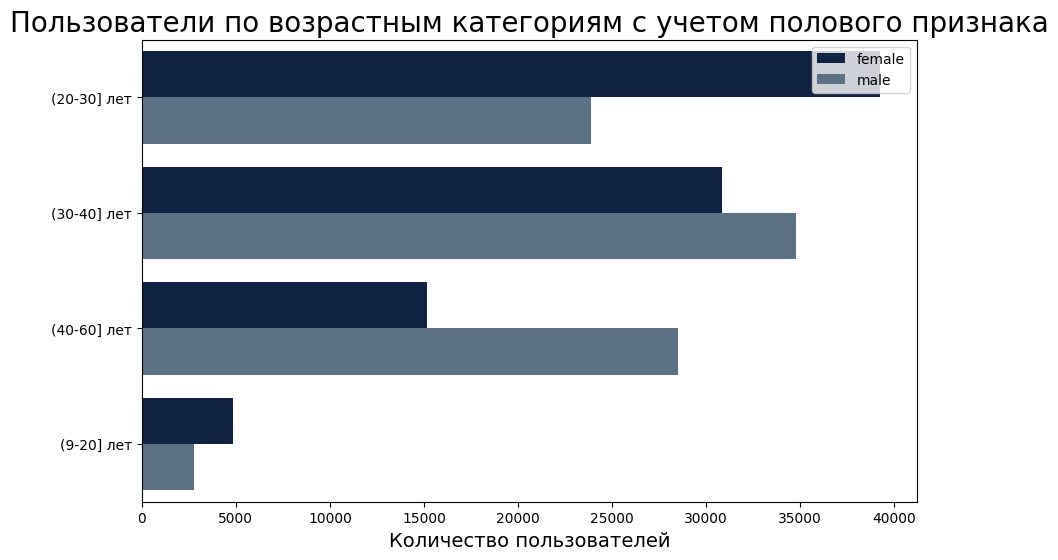

In [20]:
# визуализация пользователей по возрастным категориям с учетом полового признака
plt.figure(figsize=(10,6))
g = sns.barplot(data=df_sex_age_class_category, x="count", y="age_class_name", \
                hue="sex", palette=sns.color_palette(colors[:2]))
sns.move_legend(g, "upper right", title=None)
plt.title("Пользователи по возрастным категориям с учетом полового признака", size = 20)
plt.xlabel("Количество пользователей", size = 14)
plt.ylabel("")
plt.show()

### Данные с информацией из видео

In [21]:
video_info = pd.read_csv("data/video_info_v2.csv")
video_info.head()

rutube_video_id                                              title  \
0    video_185549  Как собрать букет из мыльных тюльпанов - Силик...   
1    video_111035        Осторожно, Киберземляне!, 1 сезон, 12 серия   
2    video_476517  ПОПУЛЯРНЫЕ ВИДЕОИГРЫ в LEGO... перевод - TD BR...   
3    video_157198                         Хороший лжец (фильм, 2019)   
4    video_289824                   Нашего старого гнобят по-всякому   

      category  duration  author_id  
0        Хобби   1559160    1015054  
1      Сериалы   1320007    1002180  
2        Хобби    606145    1095337  
3       Фильмы   6577440    1043618  
4  Развлечения    859493    1009535

In [22]:
# признаки данных
video_info.columns

Index(['rutube_video_id', 'title', 'category', 'duration', 'author_id'], dtype='object')

**video_info_v2.** - данные с информацией о видео
* rutube_video_id - id видио
* title - название видео
* category - длительность видео в миллисекундах
* duration - автор видео
* author_id - категория видео

In [23]:
# проверка на наличие пропусков
video_info.isna().sum()

rutube_video_id    0
title              0
category           0
duration           0
author_id          0
dtype: int64

Пропусков в данных **нет**

In [24]:
# проверка данных на соответствие типа
video_info.dtypes

rutube_video_id    object
title              object
category           object
duration            int64
author_id           int64
dtype: object

Типы данных **релевантны**

In [25]:
# количество уникальных значений
video_info.nunique()

rutube_video_id    481480
title              473931
category               40
duration           263461
author_id          125442
dtype: int64

In [26]:
# размернось данных
video_info.shape

(481480, 5)

В данных собрана информация по **481 480** видео в **40** категориях и **125 442** авторам

In [27]:
# проверка на наличие дубликатов
video_info.duplicated().sum()

0

Дубликатов в данных **нет**

In [28]:
# перевод миллисекунд в минуты
video_info["minuts"] = video_info["duration"] / (1000 * 60)

In [29]:
# сводная статистика по длительности видео в минутах
video_info["minuts"].describe()

count    481480.000000
mean         27.688790
std          43.045979
min           3.000017
25%           5.794167
50%          13.603800
75%          39.000883
max        1487.400250
Name: minuts, dtype: float64

In [30]:
# максимальная длительность видео в часах
round(video_info["minuts"].max() / 60, 2)

24.79

Предположительно это **сериал**, необходимо дополнительно проверить

In [31]:
# вывод видео с наибольшей продолжительностью
video_info.sort_values(by=["minuts"], ascending=False)[:10]

rutube_video_id                                              title  \
55263     video_173627  ФЭНТЕЗИ/ДЮНА/ #аудиокнига #аудиокниги #любовно...   
47766       video_7176  Красивая расслабляющая музыка • Спокойная форт...   
189079    video_330811  Тибетская целебная флейта, снимает всю негатив...   
92607     video_315356  ASMR Rain Sounds For Sleeping - Rain on Glass ...   
410105    video_132156  DJ Deepplomat Music ? Лучшая музыка 2023 ? Луч...   
423925    video_337763                Запись эфира 18.02.2024 : ТВ "СВОи"   
423128    video_238391  DJ Deepplomat Music ? Лучшая музыка 2023 ? Луч...   
365109    video_429639                                               Лето   
273090    video_471446                                  смотри трансляцию   
137014    video_282632                 Проектирование нейроинтерфейсов Д1   

            category  duration  author_id       minuts  
55263         Разное  89244015    1064995  1487.400250  
47766         Разное  87003104    1080533  1450.051733  
189079        Разное  86650068    1062692  1444.167800  
92607         Разное  86400128    1120568  1440.002133  
410105        Музыка  86400032    1028203  1440.000533  
423925  Телепередачи  86400022    1022967  1440.000367  
423128        Музыка  86394000    1028203  1439.900000  
365109        Музыка  86392044    1003606  1439.867400  
273090         Спорт  86392024    1102341  1439.867067  
137014      Обучение  86388016    1008113  1439.800267

Гипотеза **не** подтвердилась

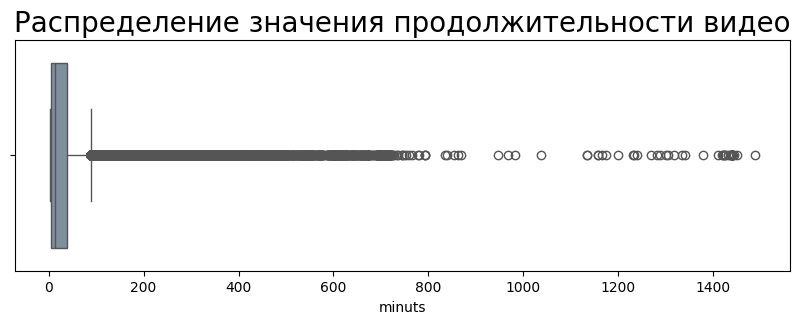

In [32]:
# визуализация распределения значения продолжительности видео
plt.figure(figsize=(10,3))
sns.boxplot(x=video_info["minuts"], color=colors[2])
plt.title("Распределение значения продолжительности видео", size = 20)
plt.show()

В основном длительность видео не превышает **100** минут

In [33]:
# категориальный признак длительности видео
cut_minuts = ["короткие", "средние", "продолжительные", "длинные"]
cut_bins = [0, 50, 100, 600, 1500]

video_info["minuts qcut"] = pd.cut(video_info["minuts"],
                              bins=cut_bins,
                              labels=cut_minuts)

In [34]:
# вывод данных
video_info.head()

rutube_video_id                                              title  \
0    video_185549  Как собрать букет из мыльных тюльпанов - Силик...   
1    video_111035        Осторожно, Киберземляне!, 1 сезон, 12 серия   
2    video_476517  ПОПУЛЯРНЫЕ ВИДЕОИГРЫ в LEGO... перевод - TD BR...   
3    video_157198                         Хороший лжец (фильм, 2019)   
4    video_289824                   Нашего старого гнобят по-всякому   

      category  duration  author_id      minuts      minuts qcut  
0        Хобби   1559160    1015054   25.986000         короткие  
1      Сериалы   1320007    1002180   22.000117         короткие  
2        Хобби    606145    1095337   10.102417         короткие  
3       Фильмы   6577440    1043618  109.624000  продолжительные  
4  Развлечения    859493    1009535   14.324883         короткие

In [35]:
# соотношение данных по категории длительности видео
(video_info["minuts qcut"].value_counts(normalize=True) * 100).round(2).astype("str") + " %"

minuts qcut
короткие           85.97 %
средние            10.03 %
продолжительные     3.91 %
длинные             0.09 %
Name: proportion, dtype: object

In [36]:
# сводная статистика длительности видео по категориям
video_info.groupby("minuts qcut", observed=True)["minuts"].describe()

count        mean         std         min         25%  \
minuts qcut                                                                 
короткие         413913.0   16.279903   13.760335    3.000017    5.172633   
средние           48311.0   67.815766   14.321243   50.000200   56.148158   
продолжительные   18823.0  159.172760   73.995119  100.000233  113.145533   
длинные             433.0  740.829033  233.405106  600.000150  601.292733   

                        50%         75%          max  
minuts qcut                                           
короткие          10.695567   23.430933    50.000000  
средние           63.275783   78.185625    99.995583  
продолжительные  130.890500  180.013483   599.615867  
длинные          668.538100  714.994650  1487.400250

In [37]:
# вывод данных
video_info.head()

rutube_video_id                                              title  \
0    video_185549  Как собрать букет из мыльных тюльпанов - Силик...   
1    video_111035        Осторожно, Киберземляне!, 1 сезон, 12 серия   
2    video_476517  ПОПУЛЯРНЫЕ ВИДЕОИГРЫ в LEGO... перевод - TD BR...   
3    video_157198                         Хороший лжец (фильм, 2019)   
4    video_289824                   Нашего старого гнобят по-всякому   

      category  duration  author_id      minuts      minuts qcut  
0        Хобби   1559160    1015054   25.986000         короткие  
1      Сериалы   1320007    1002180   22.000117         короткие  
2        Хобби    606145    1095337   10.102417         короткие  
3       Фильмы   6577440    1043618  109.624000  продолжительные  
4  Развлечения    859493    1009535   14.324883         короткие

In [82]:
# проверка наличия пропусков
video_info.isna().sum()

rutube_video_id    0
title              0
category           0
duration           0
author_id          0
minuts             0
minuts qcut        0
text               0
lemm_text_list     0
lemm_text          0
dtype: int64

In [129]:
# признак названия видео и категории
# video_info["title + category"] =  video_info["title"] + " " +  video_info["category"]

In [38]:
# публикуют ли авторы видео только в одной категории ?
video_info.groupby("author_id", as_index=False)["category"].nunique().sort_values(by=["category"], ascending=False).rename(columns={"category" : "category_count"})[:10]

author_id  category_count
5751     1005751              35
9840     1009840              25
10000    1010000              24
9052     1009052              21
6233     1006233              19
19880    1019880              19
8900     1008900              18
14304    1014304              17
4103     1004103              17
1475     1001475              16

**Нет**

In [39]:
# вывод данных
video_info.head()

rutube_video_id                                              title  \
0    video_185549  Как собрать букет из мыльных тюльпанов - Силик...   
1    video_111035        Осторожно, Киберземляне!, 1 сезон, 12 серия   
2    video_476517  ПОПУЛЯРНЫЕ ВИДЕОИГРЫ в LEGO... перевод - TD BR...   
3    video_157198                         Хороший лжец (фильм, 2019)   
4    video_289824                   Нашего старого гнобят по-всякому   

      category  duration  author_id      minuts      minuts qcut  
0        Хобби   1559160    1015054   25.986000         короткие  
1      Сериалы   1320007    1002180   22.000117         короткие  
2        Хобби    606145    1095337   10.102417         короткие  
3       Фильмы   6577440    1043618  109.624000  продолжительные  
4  Развлечения    859493    1009535   14.324883         короткие

In [40]:
# инициализация элемента класса Mystem() для последующей лемматизации текста на русском языке
m = Mystem() 

In [41]:
def lemmatize(text: str) -> str:
    """лемматизация текста

    Args:
        text (str): исходный текст

    Returns:
        str: лемматизированный текст
    """
    
    return [i for i in m.lemmatize(text) if len(i.strip()) > 0]

In [42]:
%%time
# формирование столбца 'text'
video_info["text"] = video_info["title"].apply(lambda x: x.lower())
# в тексте оставляем только кириллицу
video_info["text"] = video_info["text"].apply(lambda x: re.sub("[^а-яА-ЯёЁ]", " ", x)) 
# лемматизируем текст из столбца 'text' и формируем столбец 'lemm_text_list' - список лемматизированных слов
video_info["lemm_text_list"] = video_info["text"].apply(lemmatize)
# формируем столбец 'lemm_text' - лемматизированный тест
video_info["lemm_text"] = video_info["lemm_text_list"].apply(lambda x: ' '.join(x))


CPU times: user 1min 9s, sys: 13 s, total: 1min 22s
Wall time: 4min 49s


In [43]:
# вывод данных
video_info.head()

rutube_video_id                                              title  \
0    video_185549  Как собрать букет из мыльных тюльпанов - Силик...   
1    video_111035        Осторожно, Киберземляне!, 1 сезон, 12 серия   
2    video_476517  ПОПУЛЯРНЫЕ ВИДЕОИГРЫ в LEGO... перевод - TD BR...   
3    video_157198                         Хороший лжец (фильм, 2019)   
4    video_289824                   Нашего старого гнобят по-всякому   

      category  duration  author_id      minuts      minuts qcut  \
0        Хобби   1559160    1015054   25.986000         короткие   
1      Сериалы   1320007    1002180   22.000117         короткие   
2        Хобби    606145    1095337   10.102417         короткие   
3       Фильмы   6577440    1043618  109.624000  продолжительные   
4  Развлечения    859493    1009535   14.324883         короткие   

                                                text  \
0  как собрать букет из мыльных тюльпанов   силик...   
1        осторожно  киберземляне     сезон     серия   
2  популярные видеоигры в         перевод        ...   
3                         хороший лжец  фильм          
4                   нашего старого гнобят по всякому   

                                      lemm_text_list  \
0  [как, собирать, букет, из, мыльный, тюльпан, с...   
1           [осторожно, киберземлянин, сезон, серия]   
2                [популярный, видеоигра, в, перевод]   
3                             [хороший, лжец, фильм]   
4                 [наш, старый, гнобить, по, всякий]   

                                           lemm_text  
0  как собирать букет из мыльный тюльпан силиконо...  
1                осторожно киберземлянин сезон серия  
2                     популярный видеоигра в перевод  
3                                 хороший лжец фильм  
4                       наш старый гнобить по всякий

In [89]:
# сохранение данных в файл
video_info.to_csv("data/video_info_lemm.csv", index=False)

In [44]:
# загрузка данных с историей просмотров пользователей с известными целевыми переменными
train_uid_events = pd.read_csv("data/train_events.csv", usecols=["viewer_uid", "rutube_video_id"])
train_uid_events.head()

rutube_video_id  viewer_uid
0    video_133074    10067243
1    video_362960    10245341
2     video_96775    10894333
3    video_161610    10029092
4    video_116245    10452976

In [45]:
# проверка на наличие пропусков
train_uid_events.isna().sum()

rutube_video_id    0
viewer_uid         0
dtype: int64

Пропусков **нет**

In [47]:
# проверка на наличие дубликатов
train_uid_events.duplicated().sum()

177644

In [48]:
# размерность данных
train_uid_events.shape

(1759616, 2)

In [49]:
# удаление дубликатов
train_uid_events = train_uid_events.drop_duplicates().reset_index(drop=True)
train_uid_events.head()

rutube_video_id  viewer_uid
0    video_133074    10067243
1    video_362960    10245341
2     video_96775    10894333
3    video_161610    10029092
4    video_116245    10452976

In [50]:
train_uid_events.shape, video_info.shape, train_targets.shape

((1581972, 2), (481480, 10), (180012, 5))

In [51]:
# объединение данных
train_df = train_uid_events.merge(video_info.iloc[:, [0, -1]], on="rutube_video_id").merge(train_targets.iloc[:, [0, 2, -1]], on="viewer_uid")
train_df.head()

rutube_video_id  viewer_uid  \
0    video_133074    10067243   
1    video_362960    10245341   
2     video_96775    10894333   
3    video_161610    10029092   
4    video_116245    10452976   

                                           lemm_text     sex age_class_name  
0       папа с особенность мужской женский выпуск от  female     (9-20] лет  
1                        мальдивы андрей бебуришвили  female    (30-40] лет  
2                новый битва экстрасенс сезон выпуск    male    (20-30] лет  
3                           сергей орлов снимать дом    male    (40-60] лет  
4  искать сокровище в полевский уральский флоренц...  female    (30-40] лет

In [52]:
# проверка корректности объединения данных
train_df.shape

(1581972, 5)

Данные объединены **без** потерь

In [53]:
# выборка наименований видео и категории для мужчин, объединение в единый текст
text_male_contract = ' '.join(list(train_df.query('sex == "male"')['lemm_text'].apply(lambda x: x.lower()).values))
text_male_contract[:20]


'новый битва экстрасе'

In [54]:
# задания параметров облака слов

STOPWORDS_RU = get_stop_words("russian")

wordcloud = WordCloud(width = 2000, 
                      height = 1000, 
                      random_state=42,
                      background_color="white",
                      repeat = True,
                      collocations=False,
                      stopwords = STOPWORDS_RU)

In [55]:
# формирование облака слов для мужчин
wordcloud_male = wordcloud.generate(text_male_contract)

In [56]:
# функция визуализации облака слов
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off")

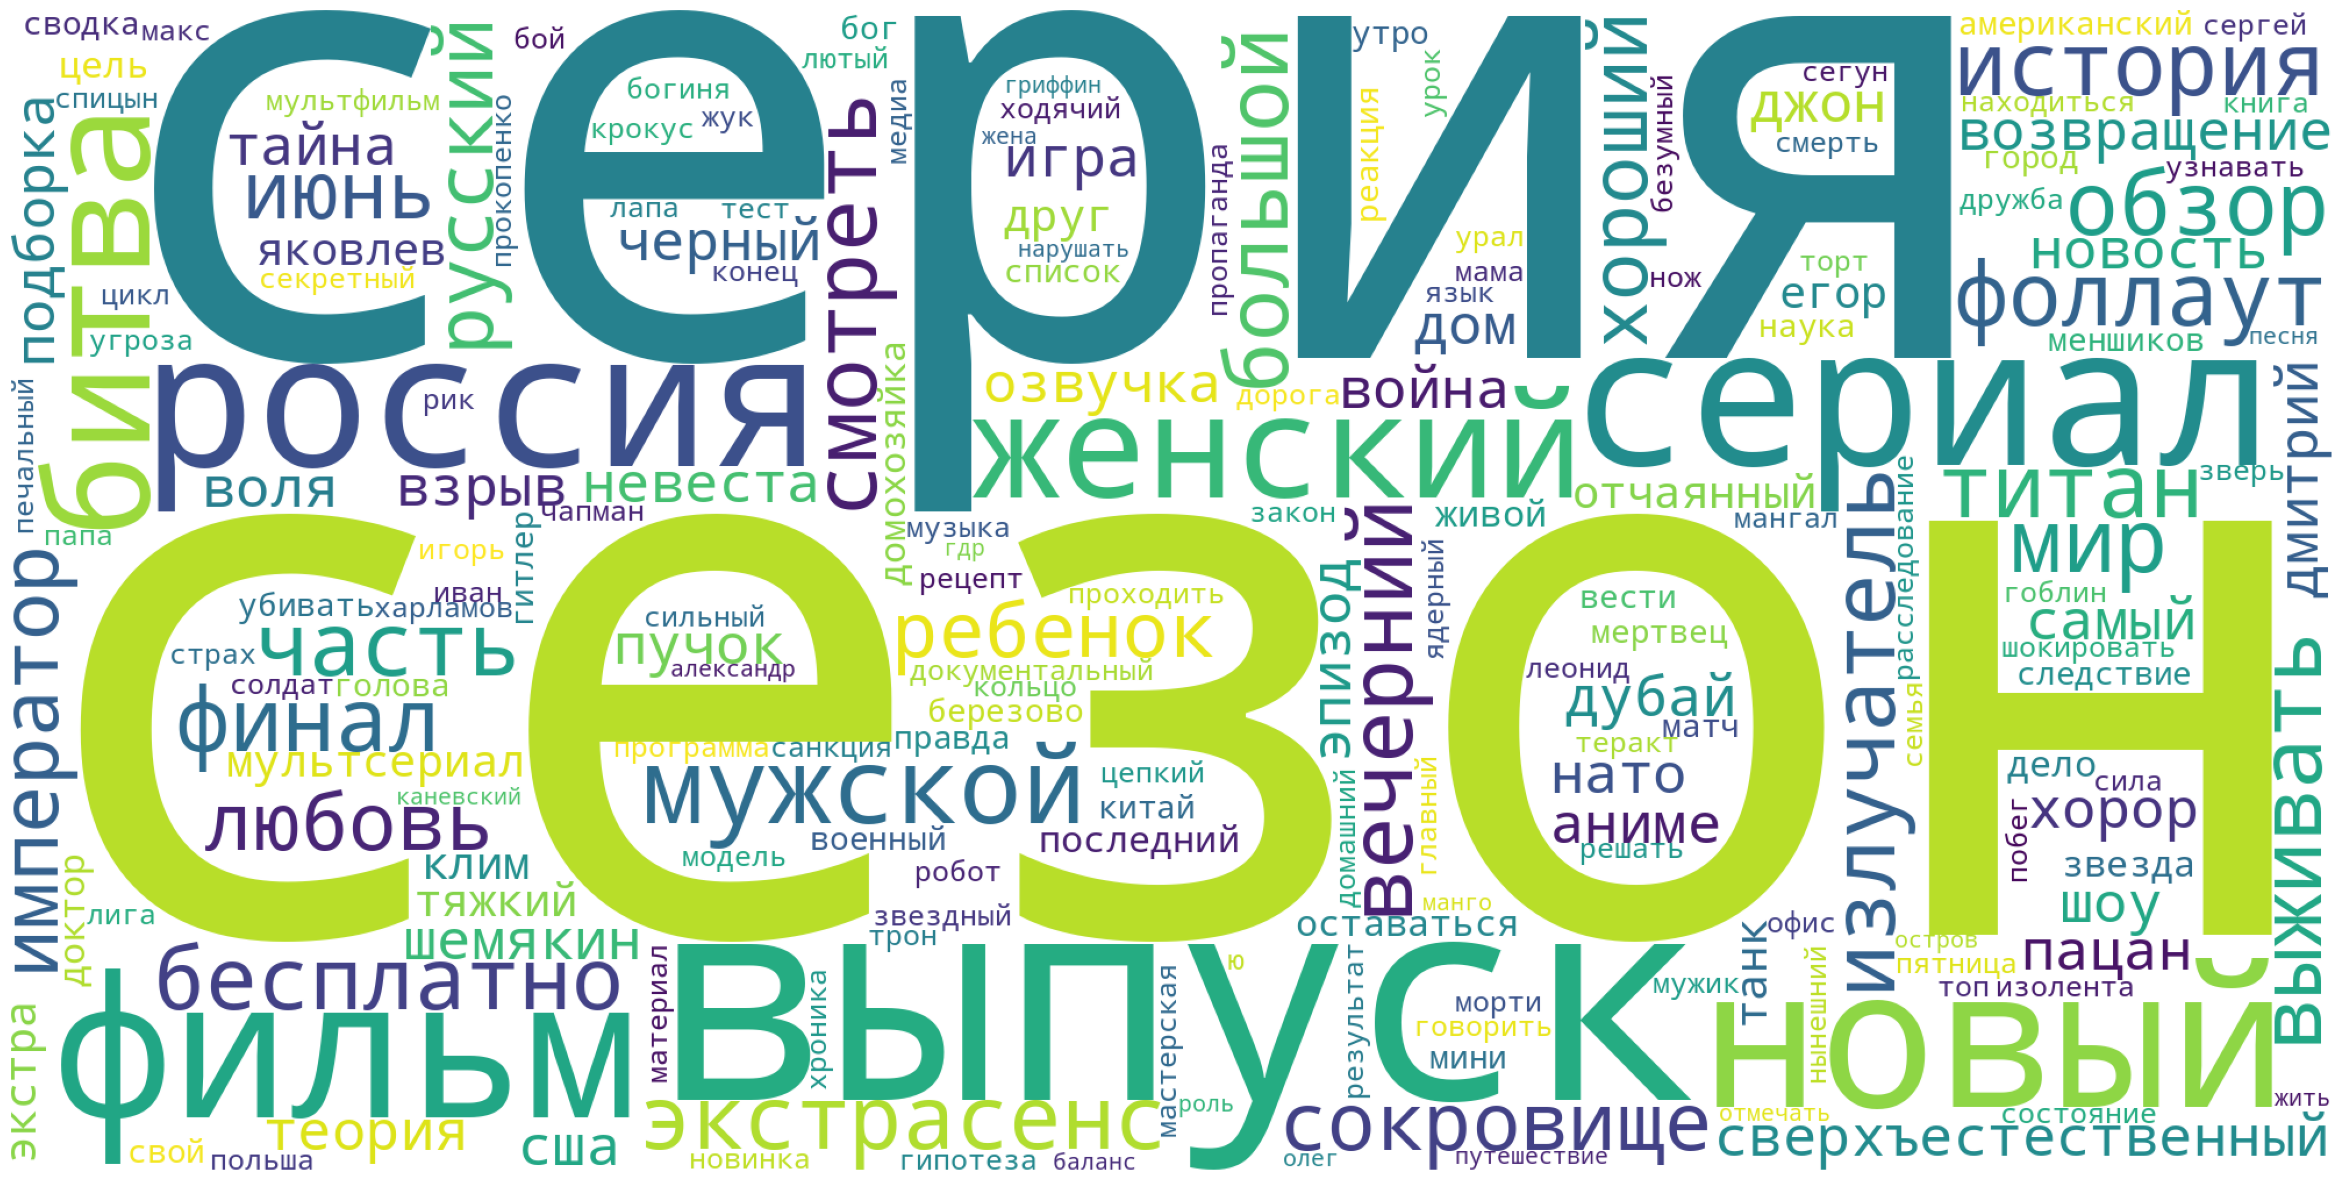

In [57]:
# визуализация сформированного облака слов для мужчин
plot_cloud(wordcloud_male)

In [58]:
# выборка наименований видео и категории для женщин, объединение в единый текст
text_female_contract = ' '.join(list(train_df.query('sex == "female"')['lemm_text'].apply(lambda x: x.lower()).values))
text_female_contract[:20]

'папа с особенность м'

In [79]:
# количество уникальных слов
len(set(text_male_contract.split()) | set(text_female_contract.split()))

42696

In [78]:
# количество уникальных слов для мужчин и женщин
len(set(text_male_contract.split()) & set(text_female_contract.split()))

21650

In [83]:
# уникальные слова описания видео для мужчин и женщин
text_male_unique =  set(text_male_contract.split()) - set(text_female_contract.split())
text_female_unique =  set(text_female_contract.split()) - set(text_male_contract.split())

In [87]:
# проверка соответствия данных
len(text_male_unique) + len(text_female_unique), 42696 - 21650

(21046, 21046)

In [59]:
# формирование облака слов для женщин
wordcloud_female = wordcloud.generate(text_female_contract)

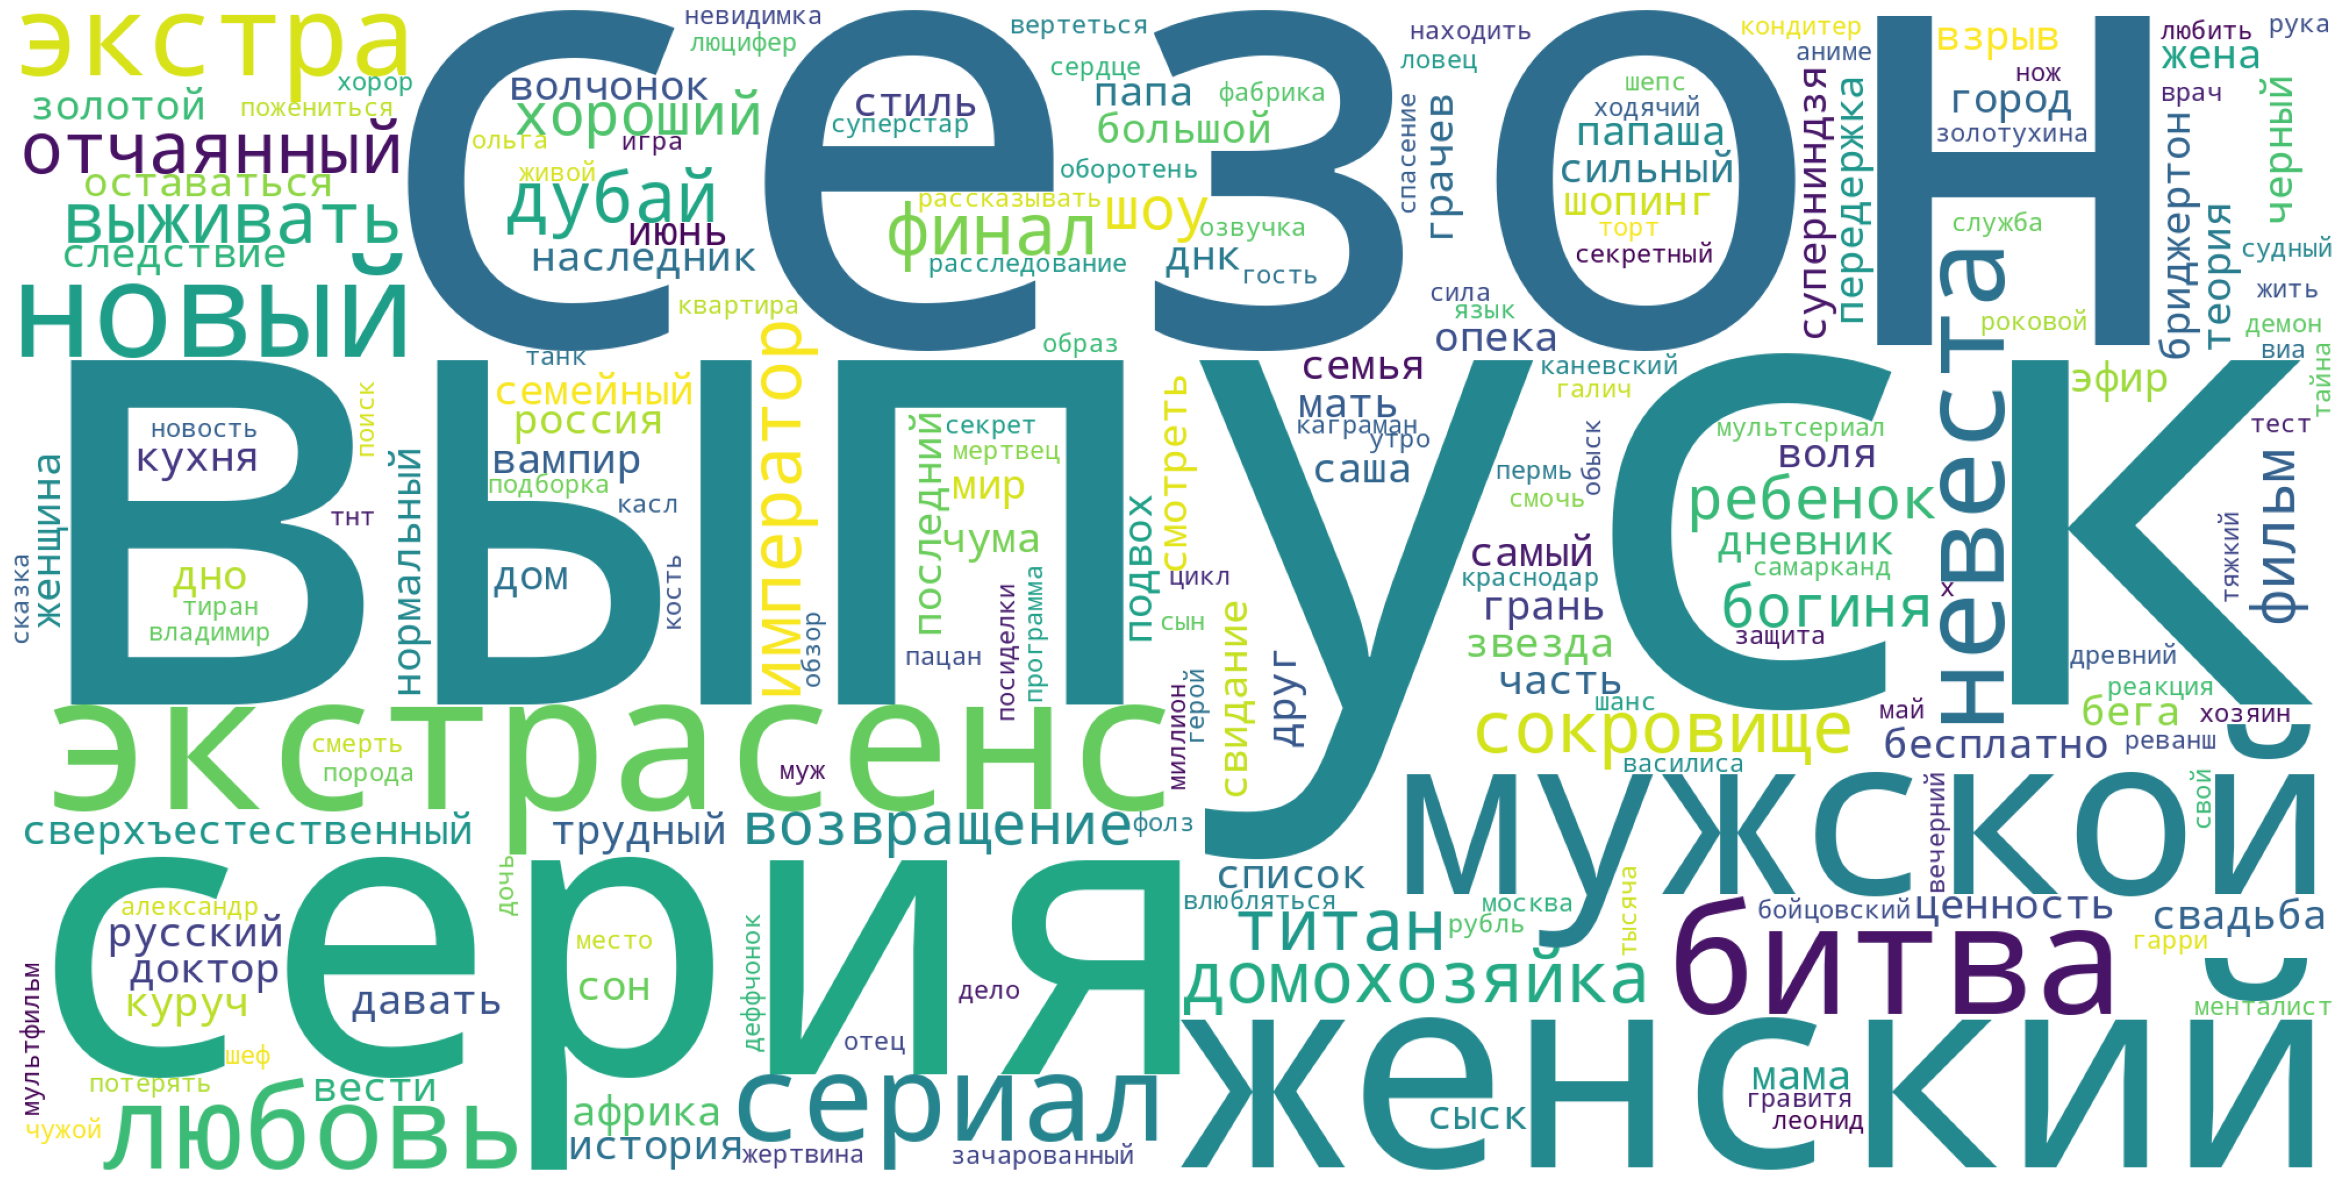

In [60]:
# визуализация сформированного облака слов для женщин
plot_cloud(wordcloud_female)

In [61]:
# выборка наименований видео и категории для возрастной категории от 9 до 20 лет
text_age_0_class_contract = ' '.join(list(train_df.query('age_class_name == "(9-20] лет"')['lemm_text'].apply(lambda x: x.lower()).values))
text_age_0_class_contract[:20]

'папа с особенность м'

In [62]:
# формирование облака слов для возрастной категории от 9 до 20 лет
wordcloud_age_0_class = wordcloud.generate(text_age_0_class_contract)

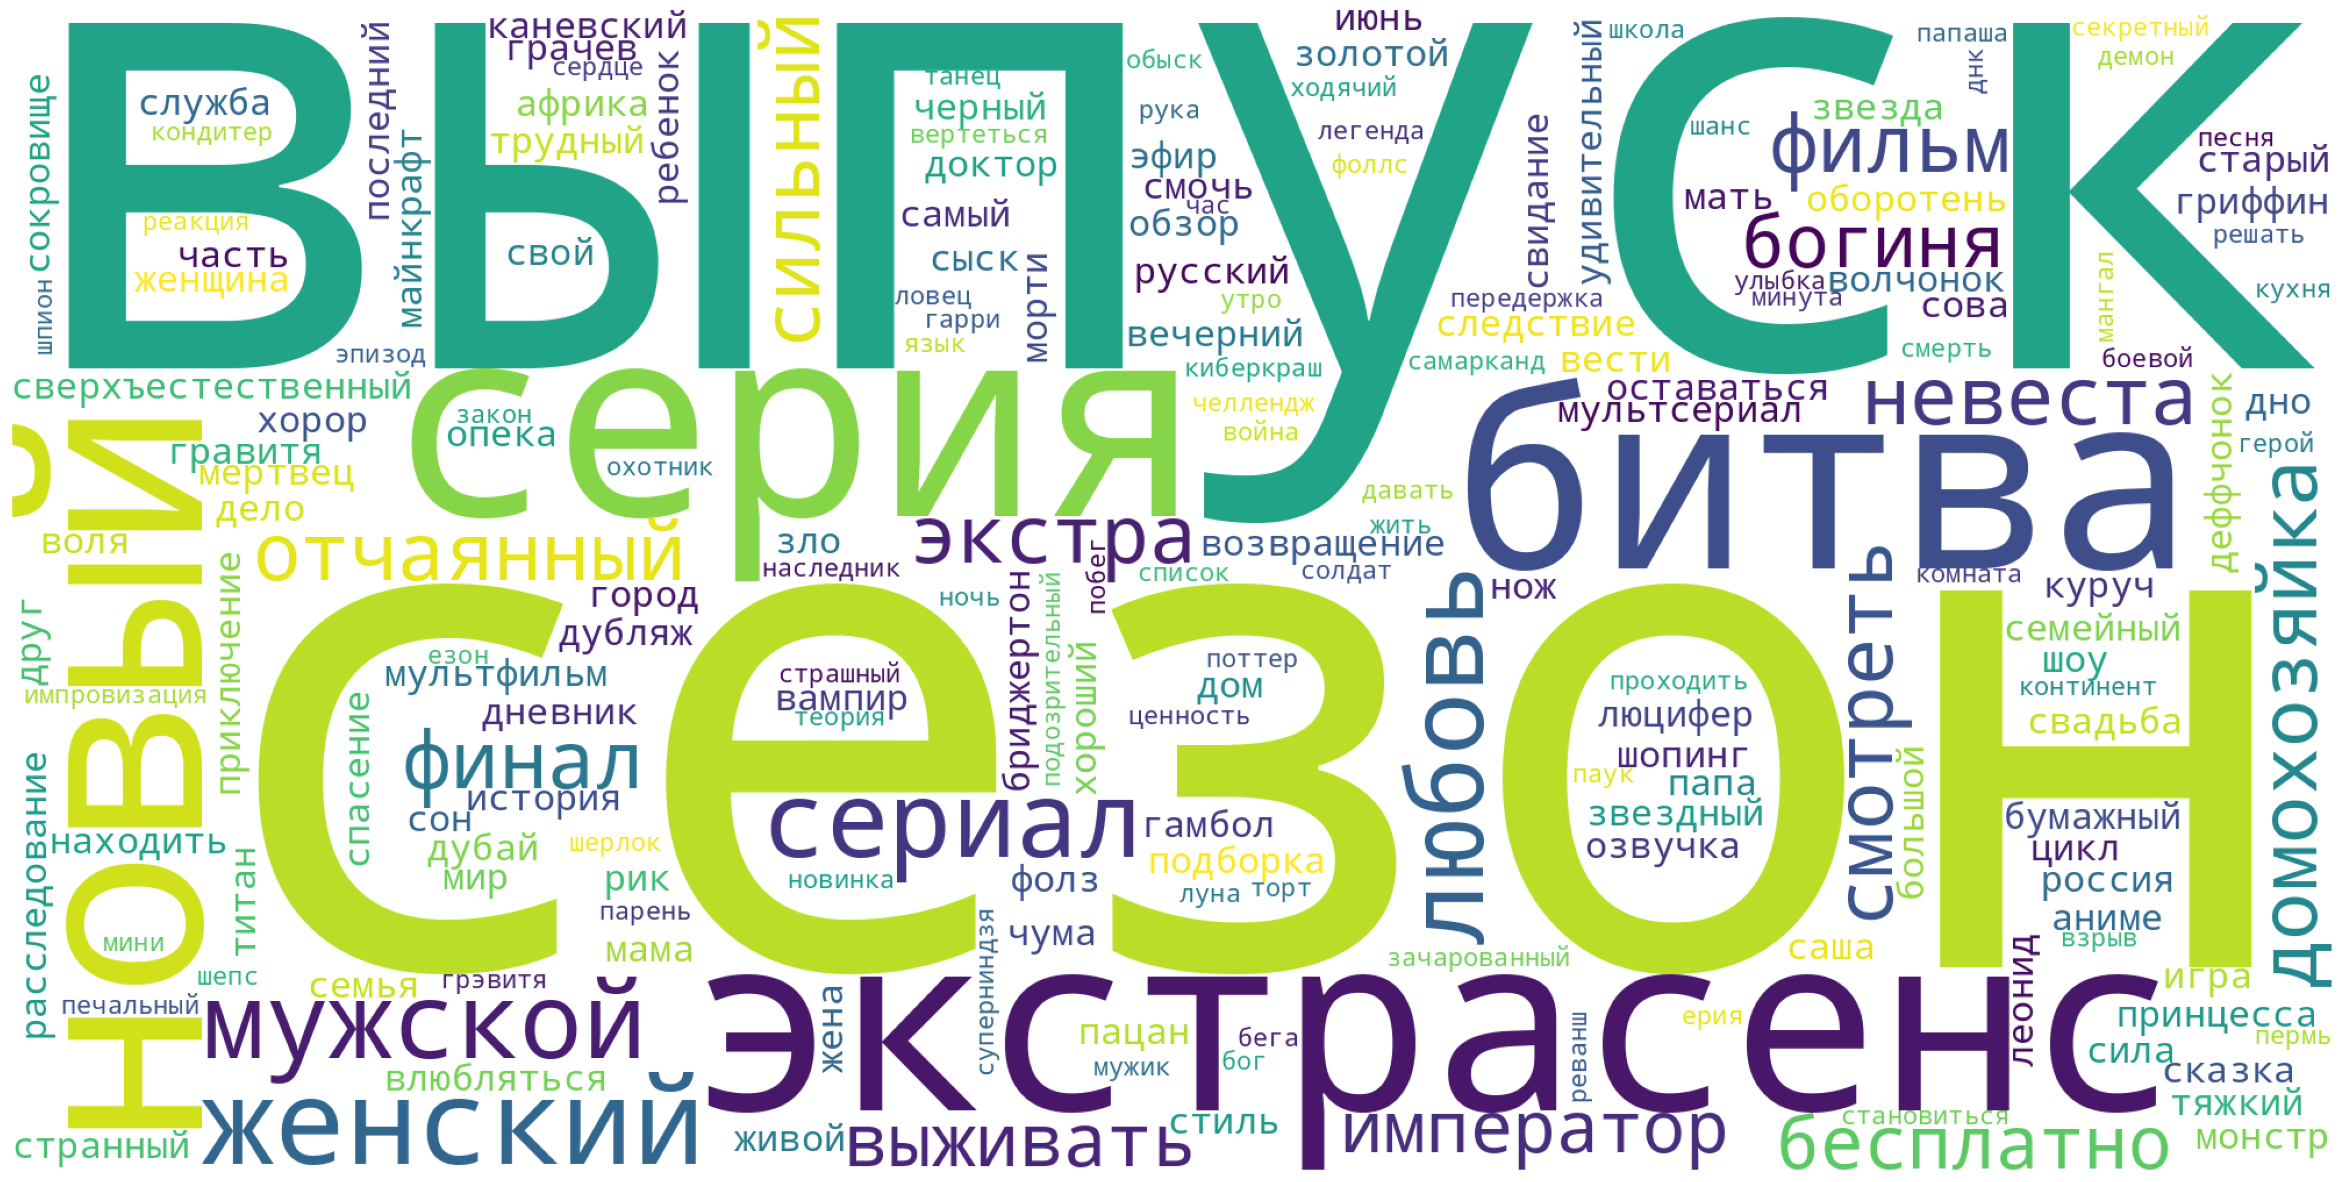

In [63]:
# визуализация сформированного облака слов для возрастной категории от 9 до 20 лет
plot_cloud(wordcloud_age_0_class)

In [64]:
# выборка наименований видео и категории для возрастной категории от 20 до 30 лет
text_age_1_class_contract = ' '.join(list(train_df.query('age_class_name == "(20-30] лет"')['lemm_text'].apply(lambda x: x.lower()).values))
text_age_1_class_contract[:20]

'новый битва экстрасе'

In [65]:
# формирование облака слов для возрастной категории от 20 до 30 лет
wordcloud_age_1_class = wordcloud.generate(text_age_1_class_contract)

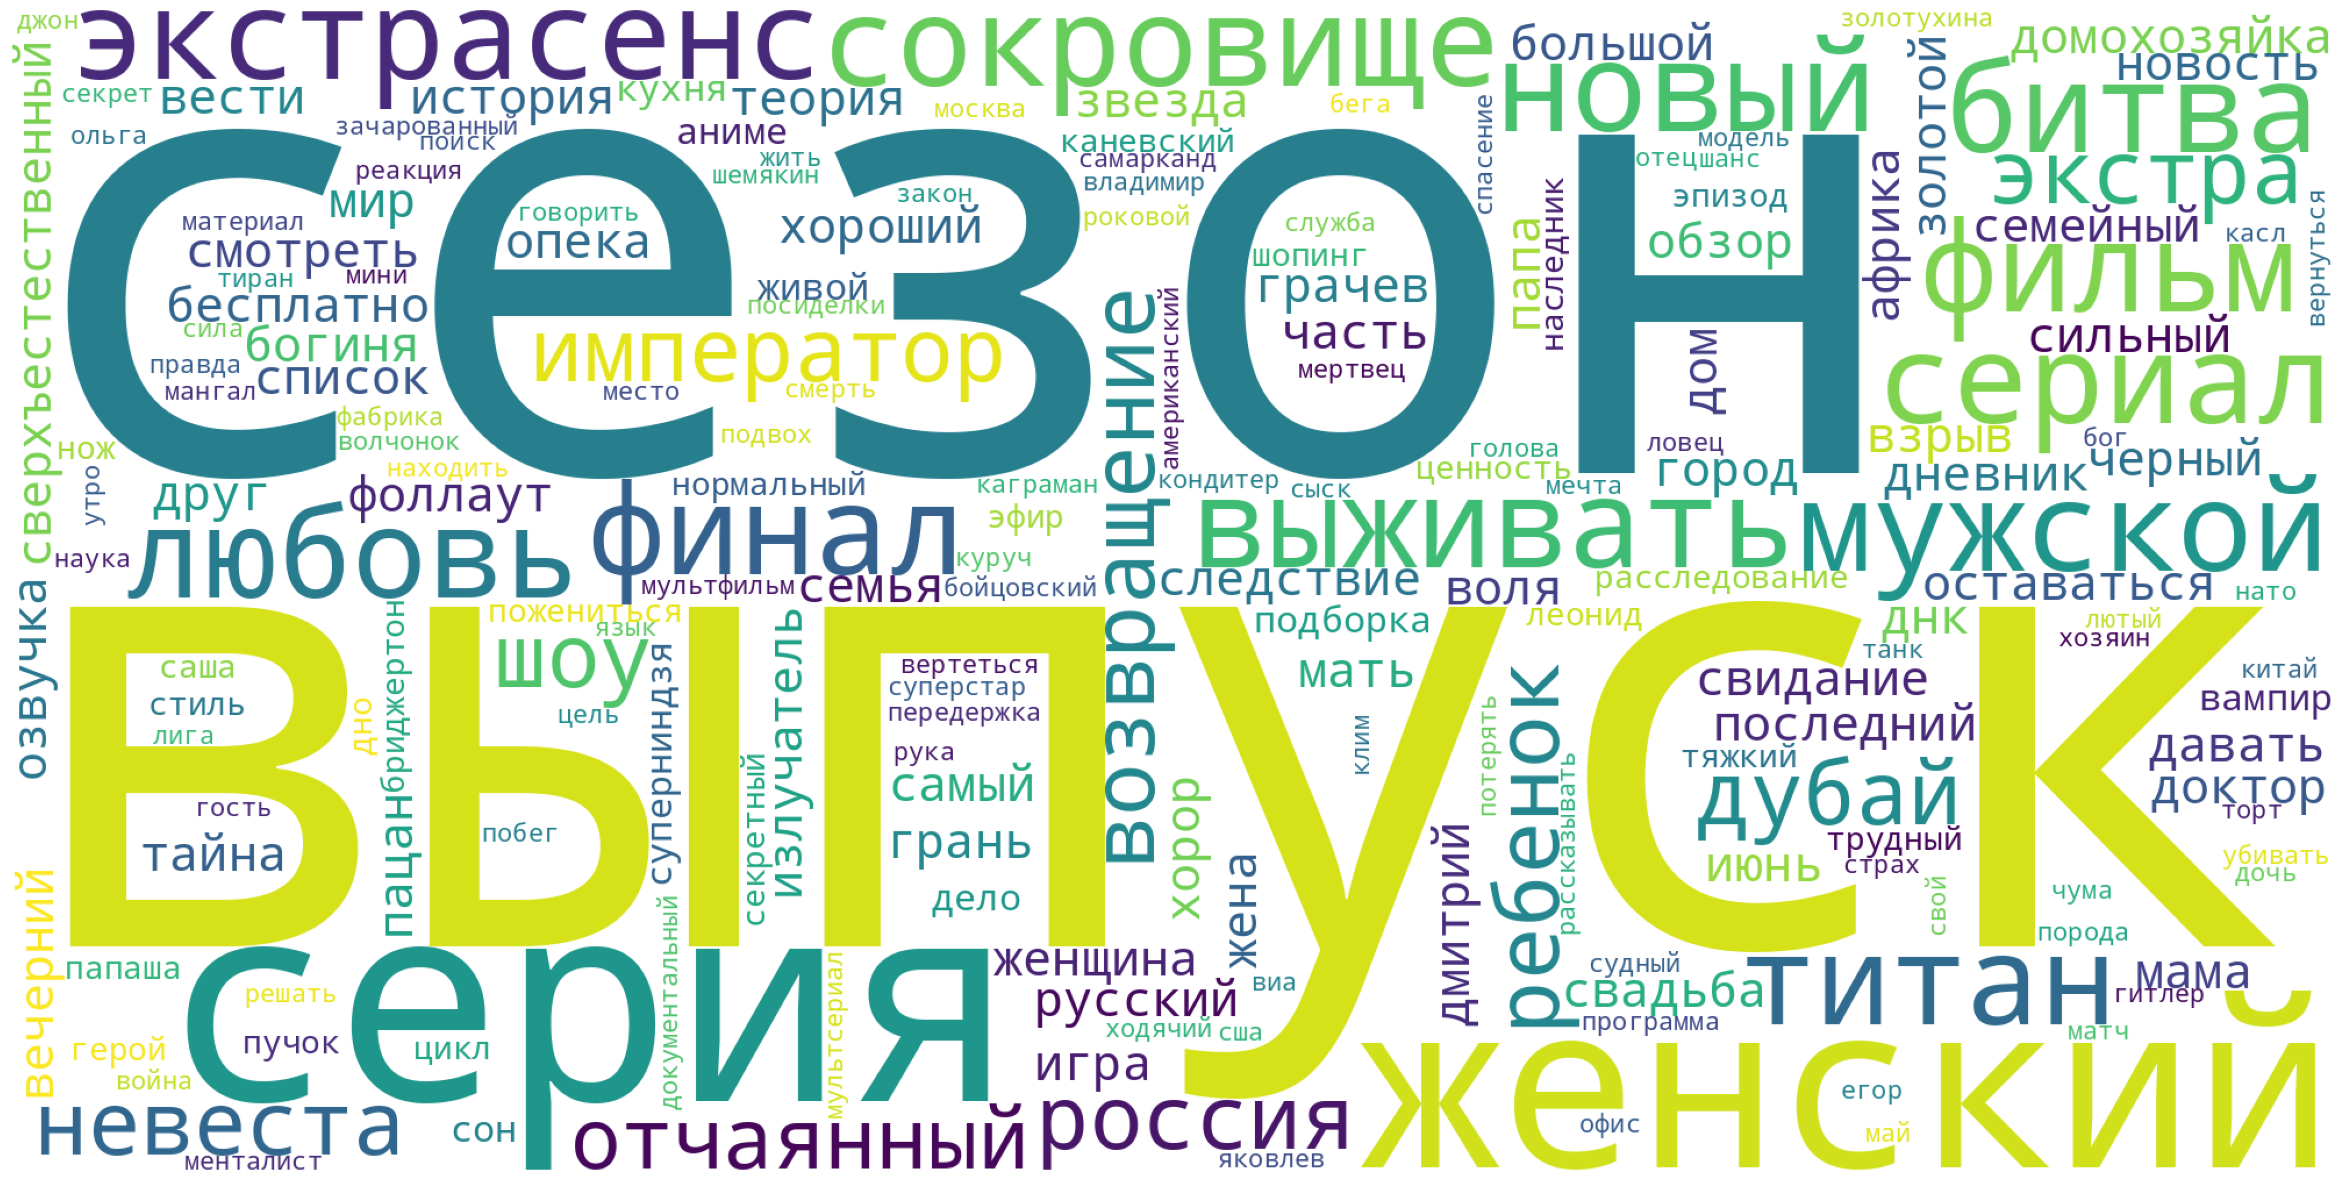

In [69]:
# визуализация сформированного облака слов для возрастной категории от 20 до 30 лет
plot_cloud(wordcloud_age_1_class)

In [70]:
# выборка наименований видео и категории для возрастной категории от 30 до 40 лет
text_age_2_class_contract = ' '.join(list(train_df.query('age_class_name == "(30-40] лет"')['lemm_text'].apply(lambda x: x.lower()).values))
text_age_2_class_contract[:20]

'мальдивы андрей бебу'

In [71]:
# формирование облака слов для возрастной категории от 30 до 40 лет
wordcloud_age_2_class = wordcloud.generate(text_age_2_class_contract)

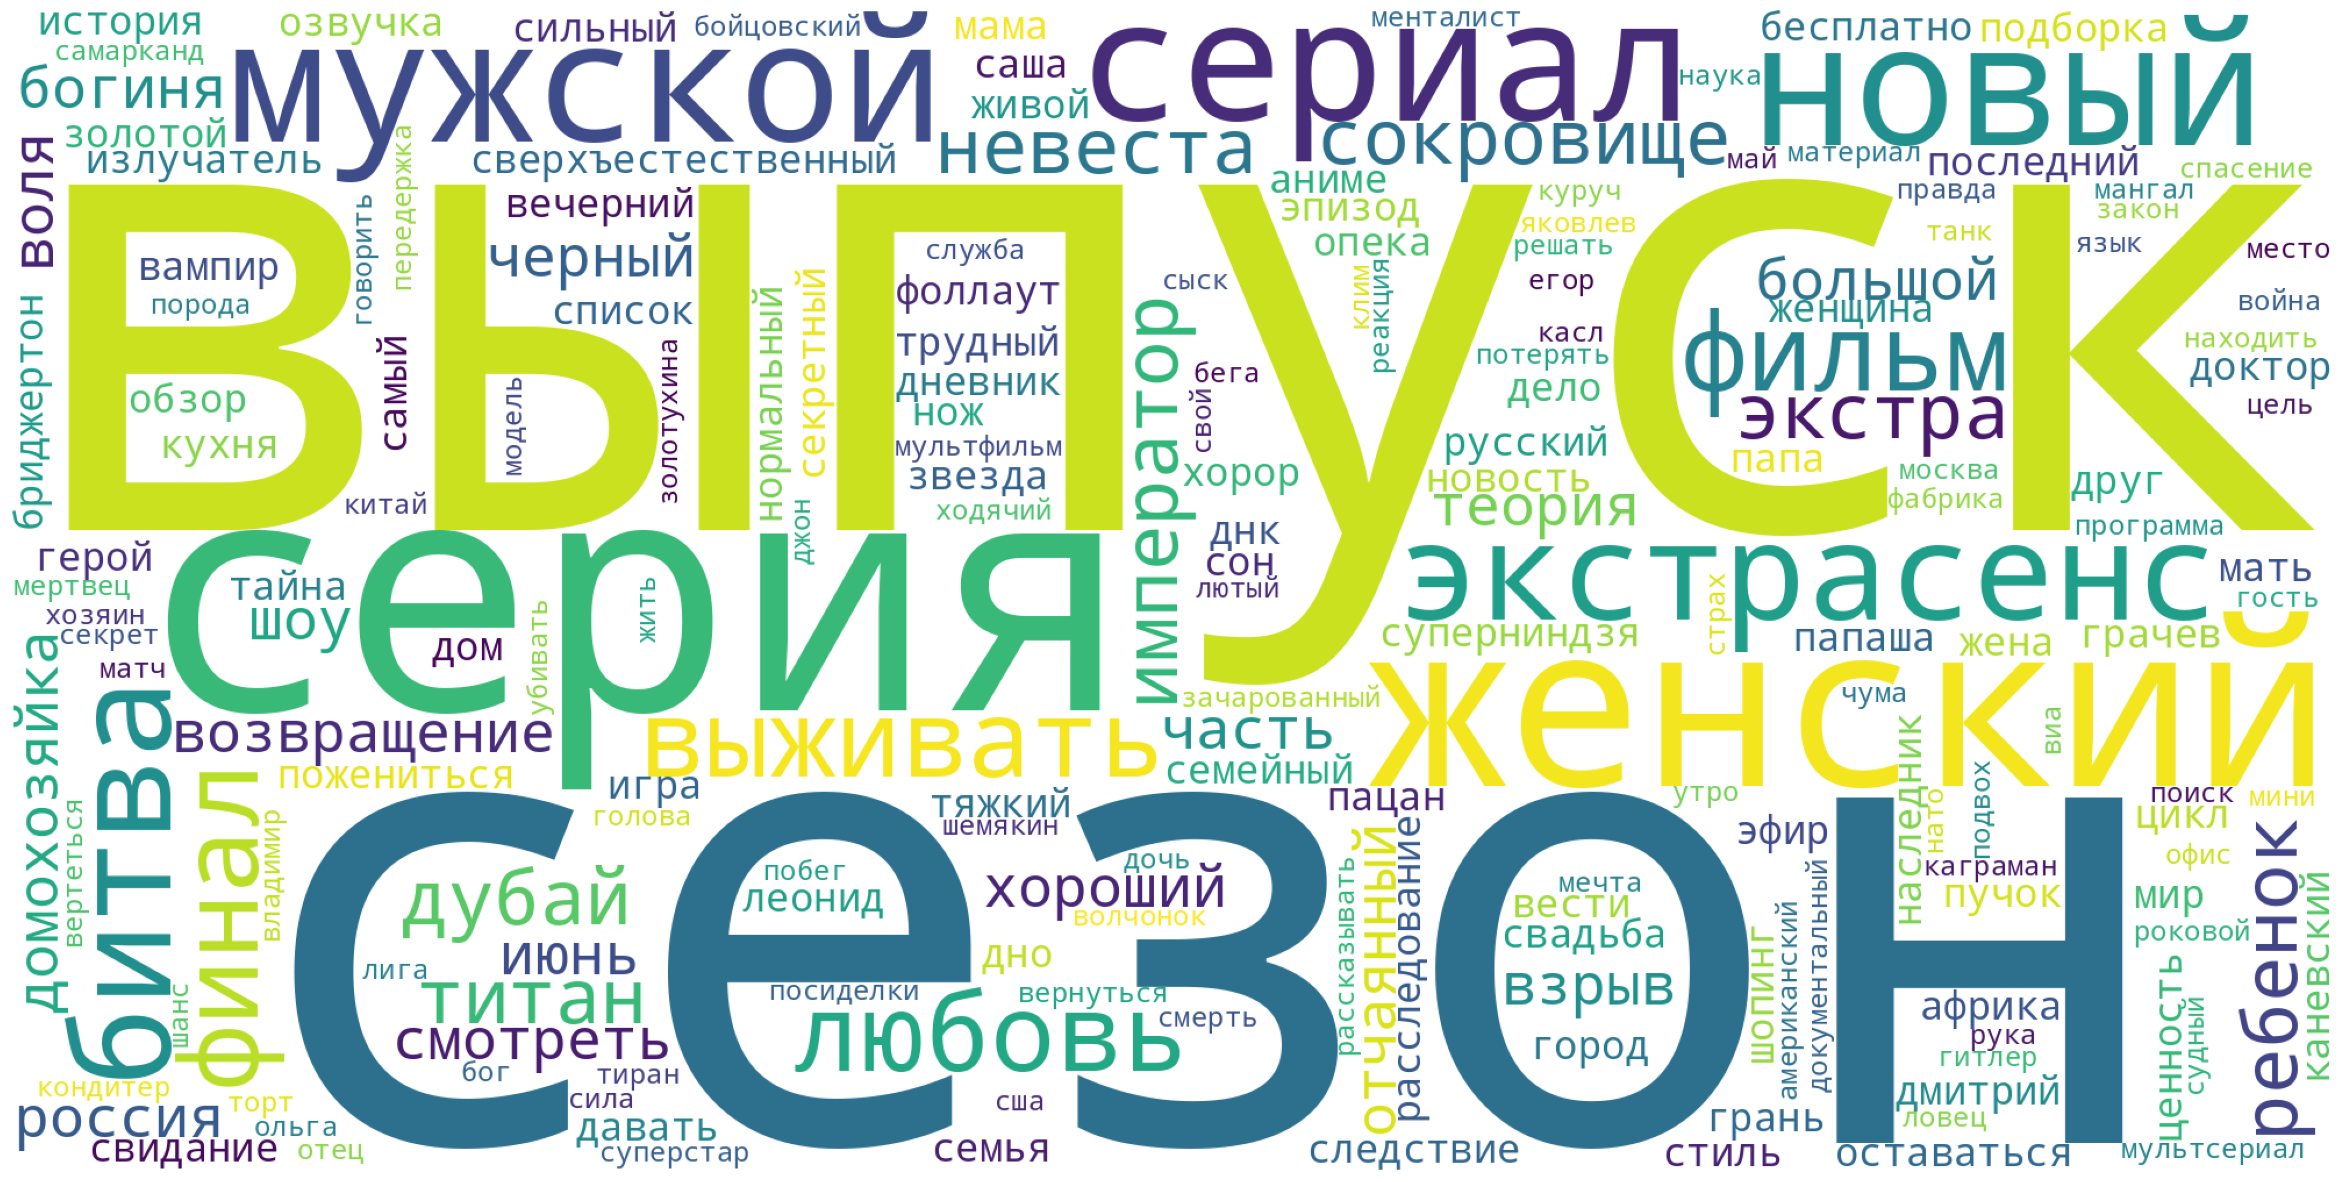

In [72]:
# визуализация сформированного облака слов для возрастной категории от 30 до 40 лет
plot_cloud(wordcloud_age_2_class)

In [73]:
# выборка наименований видео и категории для возрастной категории от 40 до 60 лет
text_age_3_class_contract = ' '.join(list(train_df.query('age_class_name == "(40-60] лет"')['lemm_text'].apply(lambda x: x.lower()).values))
text_age_3_class_contract[:20]

'сергей орлов снимать'

In [74]:
# формирование облака слов для возрастной категории от 40 до 60 лет
wordcloud_age_3_class = wordcloud.generate(text_age_3_class_contract)

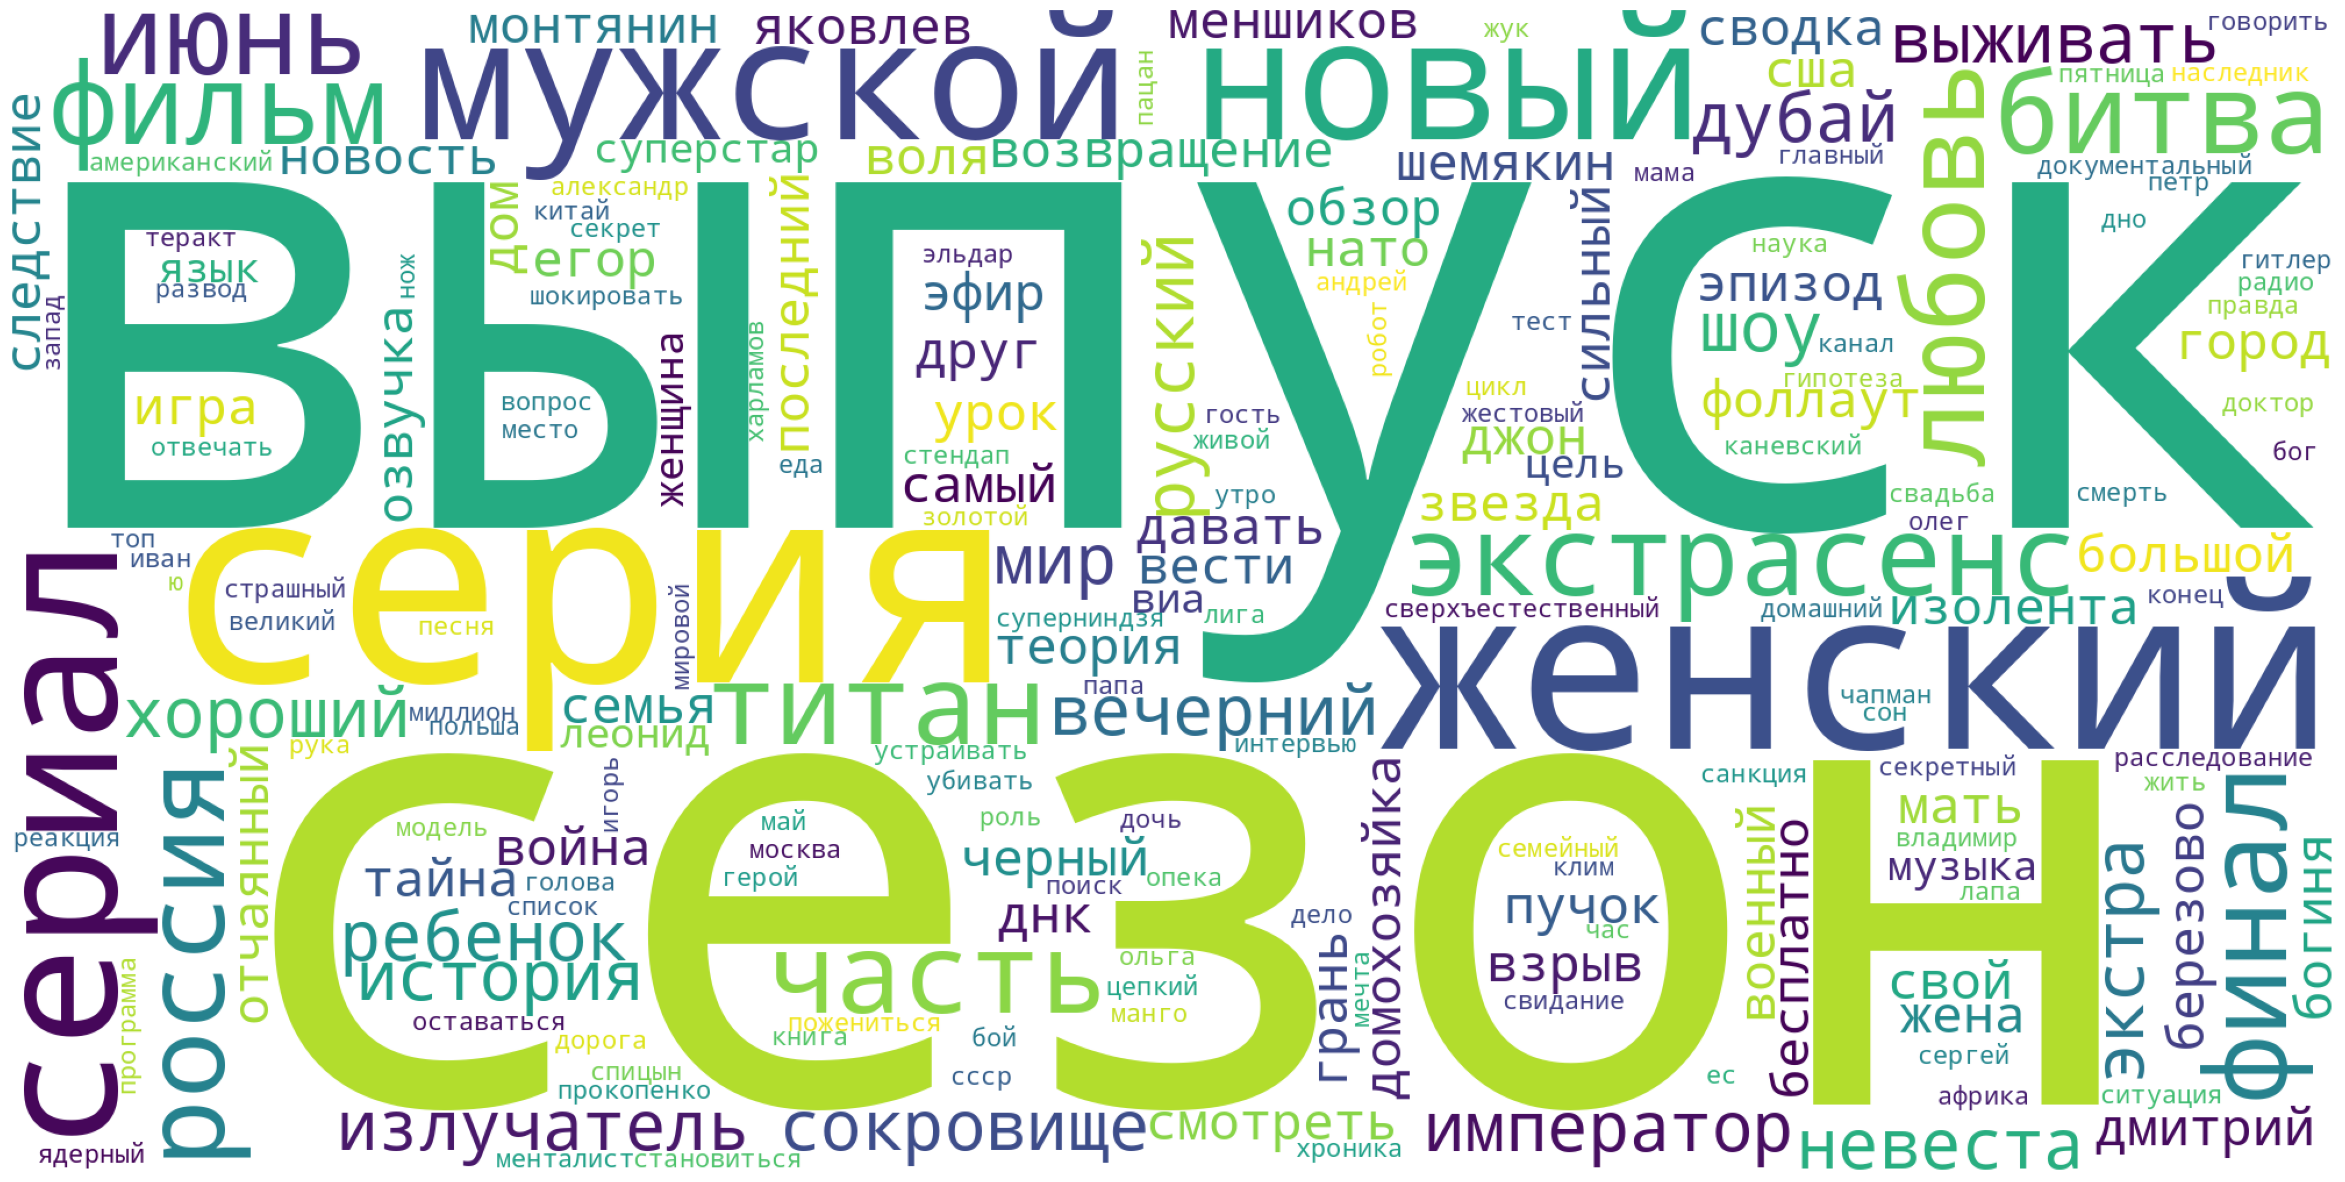

In [75]:
# визуализация сформированного облака слов для возрастной категории от 40 до 60 лет
plot_cloud(wordcloud_age_3_class)

Все категории смотрят **Битву экстрасенсов**

In [91]:
# количество уникальных слов по возастным категориям
len(set(text_age_0_class_contract.split()) | set(text_age_1_class_contract.split()) | set(text_age_2_class_contract.split()) | set(text_age_3_class_contract.split()))

42696

In [92]:
# количество общих уникальных слов
len(set(text_age_0_class_contract.split()) & set(text_age_1_class_contract.split()) & set(text_age_2_class_contract.split()) & set(text_age_3_class_contract.split()))

8823

In [93]:
# уникальные слова для возрастных категорий
text_age_0_class_unique = set(text_age_0_class_contract.split()) - set(text_age_1_class_contract.split()) - set(text_age_2_class_contract.split()) - set(text_age_3_class_contract.split())
text_age_1_class_unique = set(text_age_1_class_contract.split()) - set(text_age_0_class_contract.split()) - set(text_age_2_class_contract.split()) - set(text_age_3_class_contract.split())
text_age_2_class_unique = set(text_age_2_class_contract.split()) - set(text_age_1_class_contract.split()) - set(text_age_0_class_contract.split()) - set(text_age_3_class_contract.split())
text_age_3_class_unique = set(text_age_3_class_contract.split()) - set(text_age_1_class_contract.split()) - set(text_age_2_class_contract.split()) - set(text_age_0_class_contract.split())

In [94]:
# количество уникальных слов по категориям
len(text_age_0_class_unique), len(text_age_1_class_unique), len(text_age_2_class_unique), len(text_age_3_class_unique)

(752, 3287, 5909, 7411)

In [95]:
# вывод данных
video_info.head()

rutube_video_id                                              title  \
0    video_185549  Как собрать букет из мыльных тюльпанов - Силик...   
1    video_111035        Осторожно, Киберземляне!, 1 сезон, 12 серия   
2    video_476517  ПОПУЛЯРНЫЕ ВИДЕОИГРЫ в LEGO... перевод - TD BR...   
3    video_157198                         Хороший лжец (фильм, 2019)   
4    video_289824                   Нашего старого гнобят по-всякому   

      category  duration  author_id      minuts      minuts qcut  \
0        Хобби   1559160    1015054   25.986000         короткие   
1      Сериалы   1320007    1002180   22.000117         короткие   
2        Хобби    606145    1095337   10.102417         короткие   
3       Фильмы   6577440    1043618  109.624000  продолжительные   
4  Развлечения    859493    1009535   14.324883         короткие   

                                                text  \
0  как собрать букет из мыльных тюльпанов   силик...   
1        осторожно  киберземляне     сезон     серия   
2  популярные видеоигры в         перевод        ...   
3                         хороший лжец  фильм          
4                   нашего старого гнобят по всякому   

                                      lemm_text_list  \
0  [как, собирать, букет, из, мыльный, тюльпан, с...   
1           [осторожно, киберземлянин, сезон, серия]   
2                [популярный, видеоигра, в, перевод]   
3                             [хороший, лжец, фильм]   
4                 [наш, старый, гнобить, по, всякий]   

                                           lemm_text  
0  как собирать букет из мыльный тюльпан силиконо...  
1                осторожно киберземлянин сезон серия  
2                     популярный видеоигра в перевод  
3                                 хороший лжец фильм  
4                       наш старый гнобить по всякий

In [101]:
def text_cut_len(text: list, cut_text: set) -> int:
    """_summary_

    Args:
        text (list): список слов названия видео
        cut_text (set): уникальные слова для категории

    Returns:
        int: количество вхождений
    """

    return len(set(text) & cut_text)

In [104]:
%%time
# получение признака количества уникальных слов по категориям в названии видио
video_info["text_male_count"] = video_info["lemm_text_list"].apply(lambda x: text_cut_len(x, text_male_unique))
video_info["text_female_count"] = video_info["lemm_text_list"].apply(lambda x: text_cut_len(x, text_female_unique))
video_info["text_age_0_class_count"] = video_info["lemm_text_list"].apply(lambda x: text_cut_len(x, text_age_0_class_unique))
video_info["text_age_1_class_count"] = video_info["lemm_text_list"].apply(lambda x: text_cut_len(x, text_age_1_class_unique))
video_info["text_age_2_class_count"] = video_info["lemm_text_list"].apply(lambda x: text_cut_len(x, text_age_2_class_unique))
video_info["text_age_3_class_count"] = video_info["lemm_text_list"].apply(lambda x: text_cut_len(x, text_age_3_class_unique))

CPU times: user 3.08 s, sys: 497 μs, total: 3.08 s
Wall time: 3.07 s


In [105]:
# вывод данных
video_info.head()

rutube_video_id                                              title  \
0    video_185549  Как собрать букет из мыльных тюльпанов - Силик...   
1    video_111035        Осторожно, Киберземляне!, 1 сезон, 12 серия   
2    video_476517  ПОПУЛЯРНЫЕ ВИДЕОИГРЫ в LEGO... перевод - TD BR...   
3    video_157198                         Хороший лжец (фильм, 2019)   
4    video_289824                   Нашего старого гнобят по-всякому   

      category  duration  author_id      minuts      minuts qcut  \
0        Хобби   1559160    1015054   25.986000         короткие   
1      Сериалы   1320007    1002180   22.000117         короткие   
2        Хобби    606145    1095337   10.102417         короткие   
3       Фильмы   6577440    1043618  109.624000  продолжительные   
4  Развлечения    859493    1009535   14.324883         короткие   

                                                text  \
0  как собрать букет из мыльных тюльпанов   силик...   
1        осторожно  киберземляне     сезон     серия   
2  популярные видеоигры в         перевод        ...   
3                         хороший лжец  фильм          
4                   нашего старого гнобят по всякому   

                                      lemm_text_list  \
0  [как, собирать, букет, из, мыльный, тюльпан, с...   
1           [осторожно, киберземлянин, сезон, серия]   
2                [популярный, видеоигра, в, перевод]   
3                             [хороший, лжец, фильм]   
4                 [наш, старый, гнобить, по, всякий]   

                                           lemm_text  text_male_count  \
0  как собирать букет из мыльный тюльпан силиконо...                0   
1                осторожно киберземлянин сезон серия                0   
2                     популярный видеоигра в перевод                1   
3                                 хороший лжец фильм                0   
4                       наш старый гнобить по всякий                0   

   text_female_count  text_age_0_class_count  text_age_1_class_count  \
0                  1                       0                       0   
1                  0                       0                       0   
2                  0                       0                       0   
3                  0                       0                       0   
4                  0                       0                       0   

   text_age_2_class_count  text_age_3_class_count  
0                       0                       1  
1                       0                       0  
2                       0                       0  
3                       0                       0  
4                       0                       0